---
sidebar_label: "Running Rust programs as WebAssembly (WASM)"
sidebar_position: 15
---

# Running Rust programs as WebAssembly (WASM)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bacalhau-project/examples/blob/main/workload-onboarding/rust-wasm/index.ipynb)
[![Open In Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/bacalhau-project/examples/HEAD?labpath=workload-onboarding/rust-wasm/index.ipynb)

Bacalhau supports running jobs as a [WebAssembly (WASM)](https://webassembly.org/) program rather than using a Docker container. This examples demonstrates how to compile a [Rust](https://www.rust-lang.org/) project into WebAssembly and run the program on Bacalhau.

## Prerequisites

Make sure you have the latest `bacalhau` client installed by following the [getting started instructions](../../../getting-started/installation) or using the installation command below (which installs Bacalhau local to the notebook).

In [1]:
!command -v bacalhau >/dev/null 2>&1 || (export BACALHAU_INSTALL_DIR=.; curl -sL https://get.bacalhau.org/install.sh | bash)
path=!echo $PATH
%env PATH=./:{path[0]}

env: PATH=./:/opt/homebrew/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/usr/local/go/bin:/opt/homebrew/bin:/Users/simon/sdk/go1.18.6/bin:/Users/simon/go/bin:/opt/homebrew/share/jupyter:/Users/simon/wabt-1.0.30/bin:/opt/homebrew/opt/ruby/bin:/Users/simon/.cargo/bin


### Install Rust
You can use [`rustup`](https://rustup.rs/) to install Rust and configure it to build WASM targets.

In [2]:
!curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs -o rustup.sh
!sh rustup.sh -y
%env PATH=~/.cargo/bin:{path[0]}
!rustup target install wasm32-wasi

info: downloading installer


info: profile set to 'default'
info: default host triple is aarch64-apple-darwin


info: syncing channel updates for 'stable-aarch64-apple-darwin'


info: default toolchain set to 'stable-aarch64-apple-darwin'



  stable-aarch64-apple-darwin unchanged - rustc 1.64.0 (a55dd71d5 2022-09-19)


Rust is installed now. Great!

To get started you may need to restart your current shell.
This would reload your PATH environment variable to include
Cargo's bin directory ($HOME/.cargo/bin).

To configure your current shell, run:
source "$HOME/.cargo/env"


env: PATH=~/.cargo/bin:/opt/homebrew/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/usr/local/go/bin:/opt/homebrew/bin:/Users/simon/sdk/go1.18.6/bin:/Users/simon/go/bin:/opt/homebrew/share/jupyter:/Users/simon/wabt-1.0.30/bin:/opt/homebrew/opt/ruby/bin:/Users/simon/.cargo/bin


info: component 'rust-std' for target 'wasm32-wasi' is up to date


## Write a Rust program

We can use `cargo` (which will have been installed by `rustup`) to start a new project and compile it. 

In [3]:
!cargo init my-program

     Created binary (application) package


We can then write a Rust program. Rust programs that run on Bacalhau can read and write files, access a simple clock and make use of psudeo-random numbers. They cannot memory-map files or run code on multiple threads.

The below program will make use of the Rust `imageproc` crate to resize an image through seam carving, based on [an example from their repository](https://github.com/image-rs/imageproc/blob/master/examples/seam_carving.rs).

In [4]:
%%writefile ./my-program/src/main.rs 
use image::{open, GrayImage, Luma, Pixel};
use imageproc::definitions::Clamp;
use imageproc::gradients::sobel_gradient_map;
use imageproc::map::map_colors;
use imageproc::seam_carving::*;
use std::path::Path;

fn main() {
    let input_path = "inputs/image0.JPG";
    let output_dir = "outputs/";

    let input_path = Path::new(&input_path);
    let output_dir = Path::new(&output_dir);

    // Load image and convert to grayscale
    let input_image = open(input_path)
        .expect(&format!("Could not load image at {:?}", input_path))
        .to_rgb8();

    // Save original image in output directory
    let original_path = output_dir.join("original.png");
    input_image.save(&original_path).unwrap();

    // We will reduce the image width by this amount, removing one seam at a time.
    let seams_to_remove: u32 = input_image.width() / 6;

    let mut shrunk = input_image.clone();
    let mut seams = Vec::new();

    // Record each removed seam so that we can draw them on the original image later.
    for i in 0..seams_to_remove {
        if i % 100 == 0 {
            println!("Removing seam {}", i);
        }        
        let vertical_seam = find_vertical_seam(&shrunk);
        shrunk = remove_vertical_seam(&mut shrunk, &vertical_seam);
        seams.push(vertical_seam);
    }

    // Draw the seams on the original image.
    let gray_image = map_colors(&input_image, |p| p.to_luma());
    let annotated = draw_vertical_seams(&gray_image, &seams);
    let annotated_path = output_dir.join("annotated.png");
    annotated.save(&annotated_path).unwrap();

    // Draw the seams on the gradient magnitude image.
    let gradients = sobel_gradient_map(&input_image, |p| {
        let mean = (p[0] + p[1] + p[2]) / 3;
        Luma([mean as u32])
    });
    let clamped_gradients: GrayImage = map_colors(&gradients, |p| Luma([Clamp::clamp(p[0])]));
    let annotated_gradients = draw_vertical_seams(&clamped_gradients, &seams);
    let gradients_path = output_dir.join("gradients.png");
    clamped_gradients.save(&gradients_path).unwrap();
    let annotated_gradients_path = output_dir.join("annotated_gradients.png");
    annotated_gradients.save(&annotated_gradients_path).unwrap();

    // Save the shrunk image.
    let shrunk_path = output_dir.join("shrunk.png");
    shrunk.save(&shrunk_path).unwrap();
}

Overwriting ./my-program/src/main.rs


We also need to install the `imageproc` and `image` libraries and switch off the default features to make sure that multi-threading is disabled.

In [5]:
%%writefile ./my-program/Cargo.toml
[package]
name = "my-program"
version = "0.1.0"
edition = "2021"

[dependencies.image]
version = "0.24.4"
default-features = false
features = ["png", "jpeg", "bmp"]

[dependencies.imageproc]
version = "0.23.0"
default-features = false

Overwriting ./my-program/Cargo.toml


We can now build the Rust program into a WASM blob using `cargo`.

In [6]:
!cd my-program && cargo build --target wasm32-wasi --release

    Updating crates.io index


   Compiling autocfg v1.1.0
   Compiling cfg-if v1.0.0
   Compiling getrandom v0.1.16
   Compiling bytemuck v1.12.1
   Compiling crc32fast v1.3.2
   Compiling wasi v0.9.0+wasi-snapshot-preview1
   Compiling adler v1.0.2
   Compiling ppv-lite86 v0.2.16


   Compiling typenum v1.15.0


   Compiling rawpointer v0.2.1
    Building [                            ] 2/62: crc32fast(build.rs), adle...
   Compiling bitflags v1.3.2
    Building [>                           ] 3/62: crc32fast(build.rs), adle...
   Compiling ttf-parser v0.6.2
    Building [>                           ] 4/62: crc32fast(build.rs), ttf-...
   Compiling paste v1.0.9


   Compiling either v1.8.0
    Building [=>                          ] 6/62: crc32fast(build.rs), ttf-...
   Compiling color_quant v1.1.0


   Compiling byteorder v1.4.3


   Compiling custom_derive v0.1.7
    Building [===>                        ] 9/62: crc32fast(build.rs), ttf-...
   Compiling ab_glyph_rasterizer v0.1.7
    Building [===>                       ] 10/62: ttf-parser, getrandom(bui...
   Compiling jpeg-decoder v0.2.6


   Compiling miniz_oxide v0.5.4
    Building [====>                      ] 12/62: ttf-parser, miniz_oxide, ...
   Compiling safe_arch v0.6.0


   Compiling matrixmultiply v0.3.2
   Compiling num-traits v0.2.15


   Compiling num-integer v0.1.45
    Building [=====>                     ] 16/62: ttf-parser, miniz_oxide, ...
   Compiling num-bigint v0.4.3


   Compiling num-rational v0.4.1


   Compiling num-iter v0.1.43


   Compiling itertools v0.10.5


   Compiling conv v0.3.3


   Compiling wide v0.7.5


   Compiling owned_ttf_parser v0.6.0
    Building [==========>                ] 27/62: ttf-parser, miniz_oxide, ...


    Building [============>              ] 31/62: ttf-parser, miniz_oxide, ...


   Compiling rusttype v0.9.2
    Building [==============>            ] 35/62: ttf-parser, typenum, getr...


   Compiling flate2 v1.0.24


   Compiling rand_core v0.5.1


   Compiling rand_chacha v0.2.2


   Compiling png v0.17.6


   Compiling rand v0.7.3
    Building [================>          ] 41/62: ttf-parser, rand, rusttyp...


   Compiling num-complex v0.4.2


   Compiling approx v0.5.1


   Compiling rand_distr v0.2.2
    Building [===================>       ] 47/62: num-integer, rand, rand_d...


   Compiling simba v0.7.2


    Building [=====================>     ] 51/62: simba, rand, rand_distr, ...


    Building [======================>    ] 53/62: simba, png, num-bigint      
    Building [======================>    ] 54/62: simba, num-bigint           


   Compiling image v0.24.4
   Compiling num v0.4.0


   Compiling nalgebra v0.30.1


   Compiling imageproc v0.23.0


   Compiling my-program v0.1.0 (/Users/simon/examples/workload-onboarding/rust-wasm/my-program)


    Finished release [optimized] target(s) in 14.98s


This will generate a WASM file at `"./my-program/target/wasm32-wasi/my-program.wasm"` which can now be run on Bacalhau.

## Running WASM on Bacalhau
Now that we have a WASM binary, we can upload it to IPFS and use it as input to a Bacalhau job.

The -v switch allows specifying an IPFS CID to mount as a named volume in the job. There is also a -u switch which can download inputs via HTTP.

For this example, we are using an image of the Statue of Liberty that has been pinned to a storage facility.

In [7]:
!bacalhau wasm run ./my-program/target/wasm32-wasi/release/my-program.wasm _start \
    -v bafybeifdpl6dw7atz6uealwjdklolvxrocavceorhb3eoq6y53cbtitbeu:inputs | tee job.txt

Uploading ./my-program/target/wasm32-wasi/release/my-program.wasm to server to execute command in context, press Ctrl+C to cancel


Job successfully submitted. Job ID: 2ba45d4a-568d-46f3-b385-6cfb839475a8
Checking job status... (Enter Ctrl+C to exit at any time, your job will continue running):



	       Creating job for submission ... done ✅
	       Finding node(s) for the job ... done ✅
	             Node accepted the job ... 

done ✅
	   Job finished, verifying results ... done ✅
	      Results accepted, publishing ... 

We can now get the results. When we view the files, we can see the original image, the resulting shrunk image, and the seams that were removed.

In [8]:
!bacalhau get $(grep "Job ID:" job.txt | cut -f2 -d:)

Fetching results of job '2ba45d4a-568d-46f3-b385-6cfb839475a8'...

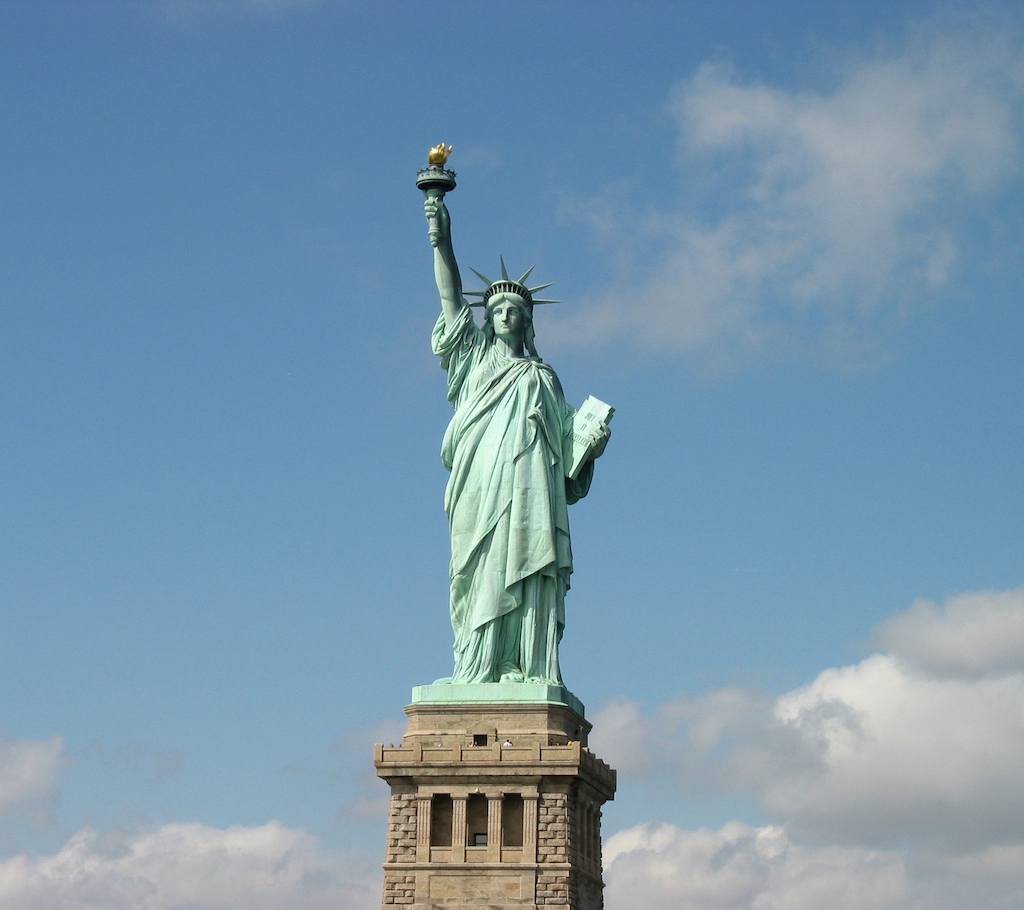

In [9]:
import IPython.display as display
display.Image("./volumes/outputs/original.png")

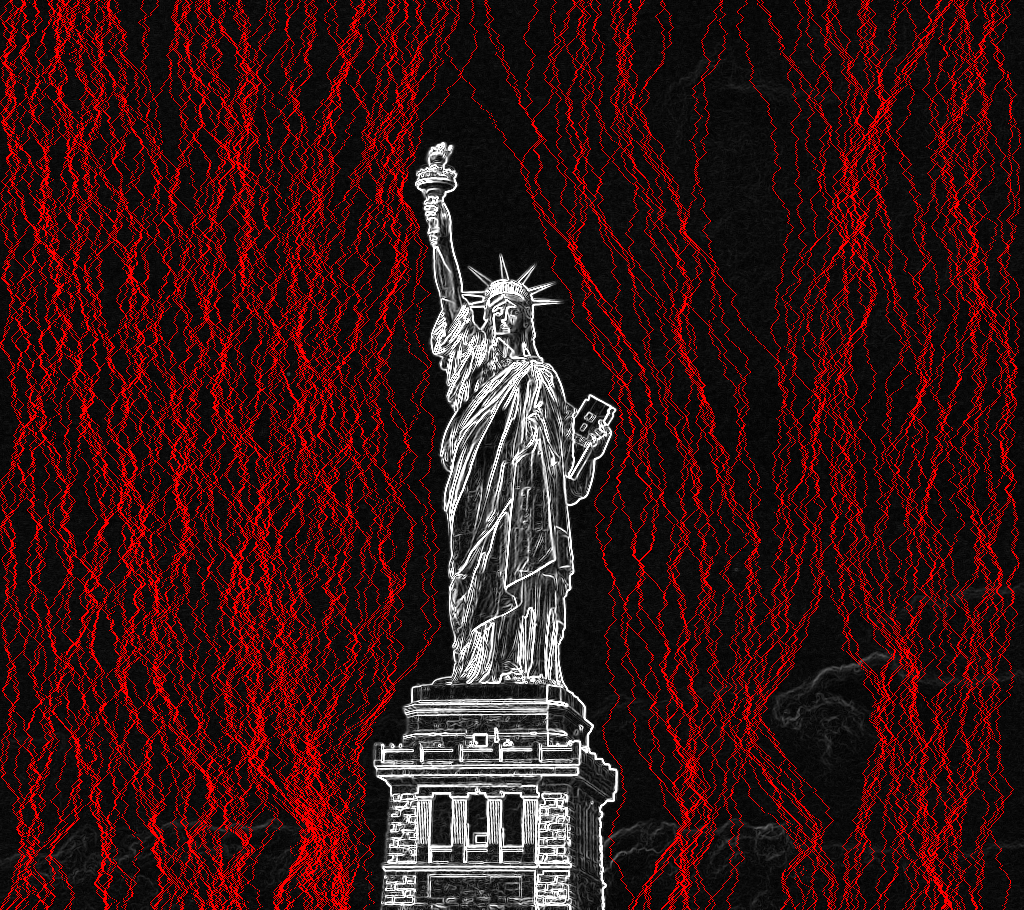

In [10]:
display.Image("./volumes/outputs/annotated_gradients.png")

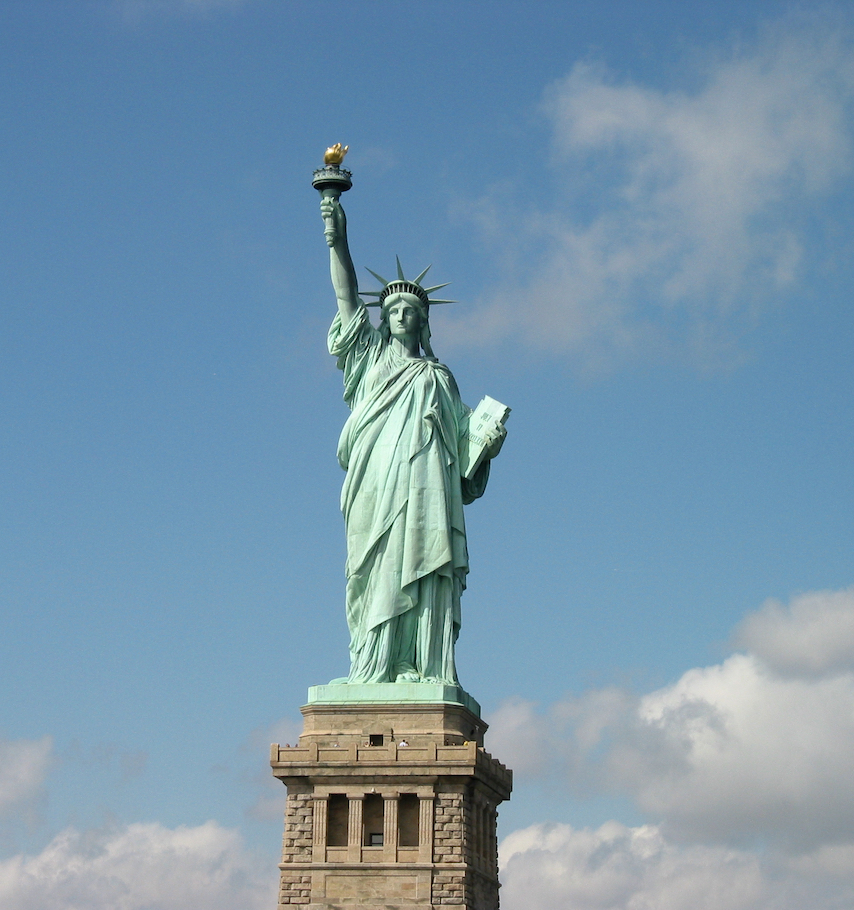

In [11]:
display.Image("./volumes/outputs/shrunk.png")